In [ ]:
#As the second step, we built a Keras model to predict drug ratings from (1-10)
#In this approach we tokenize (i.e. convert text into vectors) reviews and use it as an input for the model
#After 2 epochs of training, the model accuracy was 45%
#As this was better than the SVM perfomance, we selected Keras for further optimization 

In [2]:
import logging
import pandas as pd
import numpy as np
from numpy import random
import gensim
import nltk
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
import re

%matplotlib inline

df = pd.read_csv('drugsComTrain_raw.csv', sep = '\t')
df_t = pd.read_csv('Drug_Test.csv', sep='\t')
df.head(5)
print(df.shape)
print(df_t.shape)
df = pd.concat([df,df_t])

print(df.shape)
print(161297+53766)

(161297, 7)
(53766, 7)
(215063, 7)
215063


In [3]:
from io import StringIO

col = ['review','rating']
df = df[col]
df = df[pd.notnull(df['review'])]

df.columns = ['review','rating']

df['category_id'] = df['rating'].factorize()[0]
category_id_df = df[['rating', 'category_id']].drop_duplicates().sort_values('category_id')
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'rating']].values)

print(df['review'].apply(lambda x: len(x.split(' '))).sum())
df.head(4)

18416281


,review,rating,category_id
0,"""It has no side effect, I take it in combinati...",9.0,0
1,"""My son is halfway through his fourth week of ...",8.0,1
2,"""I used to take another oral contraceptive, wh...",5.0,2
3,"""This is my first time using any form of birth...",8.0,1


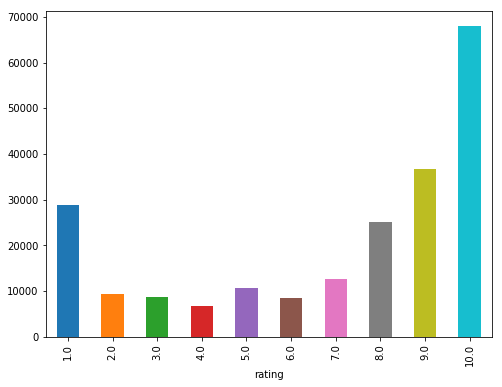

In [4]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,6))
df.groupby('rating').review.count().plot.bar(ylim=0)
plt.show()

In [5]:
def print_plot(index):
    example = df[df.index == index][['review', 'rating']].values[0]
    if len(example) > 0:
        print(example[0])
        print('Rating:', example[1])

print_plot(10)


from sklearn.model_selection import train_test_split

X = df.review
y = df.category_id

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state = 42)

print(len(y_train))
print(len(y_test))

"I have been on this medication almost two weeks, started out on 25mg and working my way up to 100mg, currently at 50mg. No headaches at all so far and I was having 2-3 crippling migraines a week. I have lost 5.2lbs so far but note I am really paying close attention to what I am eating, I have a lot of weight to lose and if weight loss is a side effect I want to help it along as much as I can.  Now, other side effects, they are there the word recall issues exist, the memory issues, the worst of it seems to be the vision disturbances, there have been times I have just not driven because I&#039;m sure it would not have been safe. The good news is it seems to be wearing off...I have tons of energy and I am in a great mood."
('Rating:', 9.0)
161297
53766


In [6]:
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text
    text = BAD_SYMBOLS_RE.sub('', text) # delete symbols which are in BAD_SYMBOLS_RE from text
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # delete stopwors from text
    return text
    
df['review'] = df['review'].apply(clean_text)
print_plot(10)
print(df_t['review'].apply(lambda x: len(x.split(' '))).sum())

medication almost two weeks started 25mg working way 100mg currently 50mg headaches far 23 crippling migraines week lost 52lbs far note really paying close attention eating lot weight lose weight loss side effect want help along much side effects word recall issues exist memory issues worst seems vision disturbances times driven i#039 sure would safe good news seems wearing offi tons energy great mood
('Rating:', 9.0)
4601711


In [7]:
from gensim.models import Word2Vec

wv = gensim.models.KeyedVectors.load_word2vec_format("GoogleNews-vectors-negative300.bin.gz", binary=True)
wv.init_sims(replace=True)

In [8]:
def word_averaging(wv, words):
    all_words, mean = set(), []
    
    for word in words:
        if isinstance(word, np.ndarray):
            mean.append(word)
        elif word in wv.vocab:
            mean.append(wv.syn0norm[wv.vocab[word].index])
            all_words.add(wv.vocab[word].index)

    if not mean:
        logging.warning("cannot compute similarity with no input %s", words)
        
        return np.zeros(wv.vector_size,)

    mean = gensim.matutils.unitvec(np.array(mean).mean(axis=0)).astype(np.float32)
    return mean

def  word_averaging_list(wv, text_list):
    return np.vstack([word_averaging(wv, review) for post in text_list ])

In [10]:
def w2v_tokenize_text(text):
    tokens = []
    for sent in nltk.sent_tokenize(text, language='english'):
        for word in nltk.word_tokenize(sent, language='english'):
            if len(word) < 2:
                continue
            tokens.append(word)
    return tokens
    
train, test = train_test_split(df, test_size=0.25, random_state = 42)

test_tokenized = test.apply(lambda r: w2v_tokenize_text(r['review']), axis=1).values
train_tokenized = train.apply(lambda r: w2v_tokenize_text(r['review']), axis=1).values

In [13]:
import itertools
import os

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.preprocessing import LabelBinarizer, LabelEncoder

from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.preprocessing import text, sequence
from keras import utils

train_size = int(len(df) * .75)
train_reviews = df['review'][:train_size]
train_ratings = df['rating'][:train_size]

test_reviews = df['review'][train_size:]
test_ratings = df['rating'][train_size:]

max_words = 1000
tokenize = text.Tokenizer(num_words=max_words, char_level=False)
tokenize.fit_on_texts(train_reviews) # only fit on train

x_train = tokenize.texts_to_matrix(train_reviews)
x_test = tokenize.texts_to_matrix(test_reviews)

encoder = LabelEncoder()
encoder.fit(train_ratings)
y_train = encoder.transform(train_ratings)
y_test = encoder.transform(test_ratings)
num_classes = np.max(y_train) + 1
y_train = utils.to_categorical(y_train, num_classes)
y_test = utils.to_categorical(y_test, num_classes)

batch_size = 32
epochs = 3

# Build the model
model = Sequential()
model.add(Dense(512, input_shape=(max_words,)))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.1)

Train on 145167 samples, validate on 16130 samples
Epoch 1/3
145167/145167 [==============================] - 105s 720us/step - loss: 1.6941 - acc: 0.4050 - val_loss: 1.6114 - val_acc: 0.4330

In [14]:
score = model.evaluate(x_test, y_test,
                       batch_size=batch_size, verbose=1)
print('Test accuracy:', score[1])

53766/53766 [==============================] - 6s 117us/step